## Scale pool area and $\Phi_{Tr}$

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [4]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
Z_zind = [30,20,14,21]

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_curv_A = np.empty(len(labels))
sb_curv_B = np.empty(len(labels))
sb_grad_A = np.empty(len(labels))
sb_grad_B = np.empty(len(labels))
sb_curv0_A = np.empty(len(labels))
sb_curv0_B = np.empty(len(labels))
sb_grad0_A = np.empty(len(labels))
sb_grad0_B = np.empty(len(labels))
sb_curvtop_A = np.empty(len(labels))
sb_curvtop_B = np.empty(len(labels))
sb_gradtop_A = np.empty(len(labels))
sb_gradtop_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,grad_array,curv_array,grad0_array,curv0_array, \
    gradtop_array,curvtop_array,sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                                                        [sb_conc_A, sb_conc_B],
                                                        [sb_grad_A, sb_grad_B],
                                                        [sb_curv_A, sb_curv_B],
                                                        [sb_grad0_A, sb_grad0_B],
                                                        [sb_curv0_A, sb_curv0_B],
                                                        [sb_gradtop_A, sb_gradtop_B],
                                                        [sb_curvtop_A, sb_curvtop_B],
                                                        [sb_Ast, sb_Bar],
                                                        [drC_A, drC_B],
                                                        [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_curv = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drc[3:]*drc[1:-2])
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
                
            sb_array[ii] = tr_profile[sb_ind]
            curv_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind+8]) # background mean 
            curvtop_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind]) # above canyon mean
            curv0_array[ii] = np.nanmean(tr_curv[sb_ind-1:sb_ind+5]) # local mean
            grad_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind+8])
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind]) 
            grad0_array[ii] = np.nanmean(tr_grad[sb_ind-1:sb_ind+5]) 
                        

In [5]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
Z_zind = [30,20,14,21]

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_gradZ_Ast = np.empty(len(labels))
sb_gradZ_Argo = np.empty(len(labels))
sb_gradZ_Bar = np.empty(len(labels))
sb_gradZ_Path = np.empty(len(labels))

sb_curvZ_Ast = np.empty(len(labels))
sb_curvZ_Argo = np.empty(len(labels))
sb_curvZ_Bar = np.empty(len(labels))
sb_curvZ_Path = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,head_ind,Z_ind,grad_array,\
    curv_array,drc,state in zip([ptr_fileA,ptr_fileA,ptr_fileB,ptr_fileB],
                                head_zind, Z_zind,
                                [sb_gradZ_Ast,sb_gradZ_Argo,
                                sb_gradZ_Bar,sb_gradZ_Path],
                                 [sb_curvZ_Ast,sb_curvZ_Argo,
                                sb_curvZ_Bar,sb_curvZ_Path],
                                [drC_A, drC_A,drC_B, drC_B],
                                [stateA,stateA,stateB,stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            tr_curv = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drc[3:]*drc[1:-2])
                
            grad_array[ii] = np.nanmean(tr_grad[head_ind:head_ind+Z_ind]) 
            curv_array[ii] = np.nanmean(tr_curv[head_ind:head_ind+Z_ind]) 
                        

### Plot area vs curvature

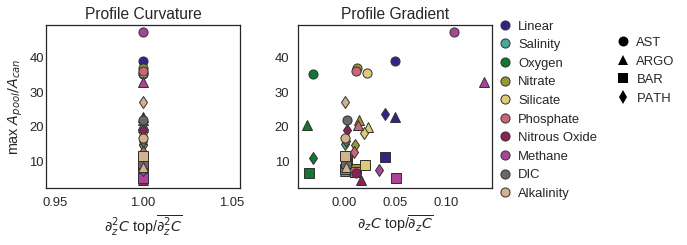

In [6]:
sns.set_style('white')
sns.set_context('talk')
fig=plt.figure(figsize=(8,3))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
labels_exp = ['Astoria', 'Ast. ARGO','Barkley', 'Bar. Path.']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                 '../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_gradZ = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_curv0 = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_curv = [sb_curv_A,sb_curv_A, sb_curv_B,sb_curv_B]
sb_grad = [sb_grad_A,sb_grad_A, sb_grad_B,sb_grad_B]
sb_curvtop = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_gradtop = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, range(len(labels_tra)),
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area,grad, curv,grad0, curv0, sbconc in zip(exp_files, 
                                                                                exp_files_BAC, 
                                                                                labels_exp, 
                                                                                can_Area,
                                                                                sb_gradZ, 
                                                                                sb_curv,
                                                                                sb_grad, 
                                                                                sb_curv, 
                                                                                sb_conc):
        Csb = sbconc[ii]
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(curv[ii]/curv0[ii],np.nanmax(area[ii,:])/can_area, 'o', 
                             mfc = col, mec='0.2',mew=1, label = tr_lab)
                    ax1.plot(10*grad[ii]/Csb,np.nanmax(area[ii,:])/can_area, 'o', 
                             mfc = col, mec='0.2',mew=1 )
                    
                else:
                    ax0.plot(curv[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, '^', 
                             mfc = col, mec='0.2',mew=1) 
                    ax1.plot(10*grad[ii]/Csb,np.nanmax(area[ii,:])/can_area, '^', 
                             mfc = col, mec='0.2',mew=1)
            else:
                if lab_exp=='Barkley':
                    ax0.plot(curv[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 's', 
                             mfc = col, mec='0.2',mew=1)
                    ax1.plot(10*grad[ii]/Csb,np.nanmax(area[ii,:])/can_area, 's', 
                             mfc = col, mec='0.2',mew=1)
                else:
                    ax0.plot(curv[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'd', 
                             mfc = col, mec='0.2',mew=1)
                    ax1.plot(10*grad[ii]/Csb,np.nanmax(area[ii,:])/can_area, 'd', 
                             mfc = col, mec='0.2',mew=1)
                 
                    

ax0.set_xlabel(r'$\partial^2_zC$ top/$\overline{\partial^2_zC}$')
ax1.set_xlabel(r'$\partial_zC$ top/$\overline{\partial_zC}$')
ax0.set_title('Profile Curvature')
ax1.set_title('Profile Gradient')
ax0.set_ylabel('max $A_{pool}/A_{can}$')
ax0.yaxis.set_tick_params(pad=2)
ax0.legend(bbox_to_anchor=(2.9,1.1), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=10),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(2,1), handletextpad=0)


plt.savefig('poolArea_vs_curvature.eps',format='eps', bbox_inches='tight')

In [10]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)

g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
Wsbs = np.array([15700,15700,13000,13000])
R = np.array([4500,4500,5000,5000])
L = np.array([21800,21800,6400,6400])
K = np.array([1E-5,1E-5,1E-5,1E-5])

slope = 1.41e-03, intercept = -262701576.136, r-value = 0.958, std_err = 6.841e-05


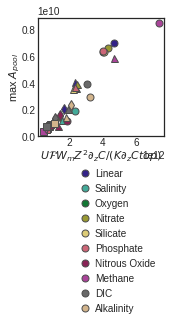

In [19]:
sns.set_style('white')
sns.set_context('notebook')
fig=plt.figure(figsize=(5,5))

gs = gspec.GridSpec(2, 2, hspace=0.3,wspace=0.2)

ax0 = plt.subplot(gs[0,0])
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv0 = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_curv = [sb_curvZ_Ast,sb_curvZ_Argo, sb_curvZ_Bar,sb_curvZ_Path]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_curvtop = [sb_curvtop_A,sb_curvtop_A, sb_curvtop_B,sb_curvtop_B]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]
Hhs = [97.5,97.5,172.5,172.,5]
Hss = [150,150,200,200]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad0,curv0,grad,curv,gradtop,curvtop,conc,Hh,ff,nn,uu,ll,ww,wsb,ss,KK,rr, mark in zip(exp_files, 
                                                                                          runs,runs_phi,
                                                                                          labels_exp,
                                                                                          can_Area,exps,
                                                                                          sb_grad0,sb_curv0,
                                                                                          sb_grad,sb_curv,
                                                                                          sb_gradtop,sb_curvtop,
                                                                                          sb_conc,Hhs,
                                                                                          f,N,U,L,Wiso,Wsbs,s,K,R,
                                                                                          markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,rr))
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii])),
                             np.nanmax(area[ii,:]), 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    Pi_array[kk]=((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
                else:
                    ax0.plot(((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii])),
                             np.nanmax(area[ii,:]), '^', mfc = col, mec='0.3',mew=1) 
                    Pi_array[kk]=((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
            else:
                if lab_exp=='BAR':
                    ax0.plot((uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii])),
                             np.nanmax(area[ii,:]), 's', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=(uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
                else:
                    ax0.plot((uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii])),
                             np.nanmax(area[ii,:]), 'd', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=(uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)

ax0.legend(bbox_to_anchor=(1,-0.2), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(1.5,1), handletextpad=0)
ax0.set_xlabel(r'$U\mathcal{F}W_mZ^2\partial_zC/(K \partial_zC top)$', labelpad=0)
ax0.set_ylabel('max $A_{pool}$', labelpad=0)

slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(Pi_array,area_array)

print('slope = %1.2e, intercept = %1.3f, r-value = %1.3f, std_err = %1.3e' \
      %(slope0, intercept0, r_value0, std_err0))


In [20]:
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv0 = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_curv = [sb_curvZ_Ast,sb_curvZ_Argo, sb_curvZ_Bar,sb_curvZ_Path]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_curvtop = [sb_curvtop_A,sb_curvtop_A, sb_curvtop_B,sb_curvtop_B]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]
Hhs = [97.5,97.5,172.5,172.,5]

Phi_array = np.zeros(40)
x_array = np.zeros(40)
kk = 0

for tr, ii in zip(tracer_keys, range(len(labels_tra))):
    for run_phi,lab_exp,exp,grad,conc,ff,nn,uu,ll,ww,ss, mark in zip(runs_phi,
                                                                     labels_exp,
                                                                     exps,
                                                                     sb_grad,
                                                                     sb_conc,
                                                                     f,N,U,L,Wiso,s,
                                                                     markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        Phi_array[kk]=PhiTr/(Phi*Cs)
        x_array[kk] = ZZ*grad[ii]/Cs
        kk = kk+1 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_array,Phi_array)

print('slope = %1.2f, intercept = %1.3f, r-value = %1.3f, std_err = %1.3f' \
      %(slope, intercept, r_value, std_err))


slope = 0.57, intercept = 0.982, r-value = 0.966, std_err = 0.025


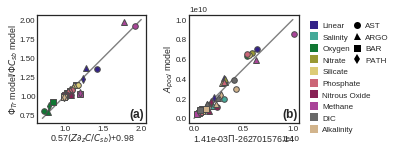

In [26]:
sns.set_style('white')
sns.set_context('paper')

fig,(ax0,ax1) =plt.subplots(1,2,figsize=(5,2))
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']
exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
markers=['o','^','s','d']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv = [sb_curvZ_Ast,sb_curvZ_Argo, sb_curvZ_Bar,sb_curvZ_Path]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]

ax0.plot(np.linspace(0.7,2,20),np.linspace(0.7,2,20),'-',color='0.5')
ax1.plot(np.linspace(0,1E10,50),
         np.linspace(0,1E10,50),'-',color='0.5')

for tr_lab,tr, ii, col in zip(labels_tra,tracer_keys, range(len(labels_tra)),colours):
    for file,run,run_phi,lab_exp,can_area,exp,grad,gradtop,conc,ff,nn,uu,ll,ww,wsb,ss,KK,rr, mark in zip(exp_files,
                                                                                                          runs,
                                                                                                          runs_phi,
                                                                                                          labels_exp,
                                                                                                          can_Area,                
                                                                                                          exps,
                                                                                                          sb_grad,
                                                                                                          sb_gradtop,
                                                                                                          sb_conc,
                                                                                                          f,N,U,L,Wiso,Wsbs,
                                                                                                          s,K,R,
                                                                                                          markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,rr))
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file2)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
    
        ax0.plot(slope*(ZZ*grad[ii]/Cs)+intercept,PhiTr/(Phi*Cs), marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
       
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 'o', mfc = col, mec='0.3',
                             mew=1, label = tr_lab)
                else:
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), '^', mfc = col, mec='0.3',
                             mew=1)
            else:
                if lab_exp=='BAR':
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 's', mfc = col, mec='0.3',
                             mew=1)
                else:
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 'd', mfc = col, mec='0.3',
                             mew=1)
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(3.3,1.0), handletextpad=0)

legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1), handletextpad=0)
ax1.set_xlabel(r'%1.2e$\Pi $%1.2f' %(slope0,intercept0), labelpad=0)
ax0.set_xlabel(r'%1.2f$(Z \partial_zC/C_{sb})$+%1.2f' %(slope,intercept), labelpad=0)

ax0.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)
ax1.set_ylabel('$A_{pool}$ model', labelpad=0)
ax0.set_aspect(1)
ax1.set_aspect(1)

ax0.text(0.85,0.05,'(a)',fontsize=12, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',fontsize=12, fontweight='bold',  transform=ax1.transAxes)

plt.savefig('scaling.eps',format='eps', bbox_inches='tight')